In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)

plt.rcParams["figure.figsize"] = (10, 6)


In [4]:
catalog = pd.read_csv("../data/current_catalog.csv")
trajectory = pd.read_csv("../data/trajectory_timeseries.csv")


In [5]:
catalog.info()
catalog.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14498 entries, 0 to 14497
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   norad_id                 14498 non-null  int64  
 1   name                     14498 non-null  object 
 2   object_type              14498 non-null  object 
 3   satellite_constellation  14498 non-null  object 
 4   altitude_km              14498 non-null  float64
 5   altitude_category        14498 non-null  object 
 6   orbital_band             14498 non-null  object 
 7   congestion_risk          14498 non-null  object 
 8   inclination              14498 non-null  float64
 9   eccentricity             14498 non-null  float64
 10  launch_year_estimate     14498 non-null  int64  
 11  days_in_orbit_estimate   14498 non-null  int64  
 12  orbit_lifetime_category  14498 non-null  object 
 13  mean_motion              14498 non-null  float64
 14  epoch                 

,norad_id,altitude_km,inclination,eccentricity,launch_year_estimate,days_in_orbit_estimate,mean_motion
count,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000
mean,56815.928059,2330.674590,59.611658,0.002723,2023.991723,0.141054,14.269553
std,8632.569867,7569.058533,23.741511,0.038953,0.090604,1.043991,3.218797
min,900.000000,136.628422,0.001900,0.000004,2023.000000,0.000000,0.283395
25%,52499.250000,475.226045,43.003600,0.000123,2024.000000,0.000000,14.983544
50%,58583.000000,539.710268,53.159700,0.000153,2024.000000,0.000000,15.088508
75%,63663.500000,571.980423,81.306025,0.000306,2024.000000,0.000000,15.301963
max,67646.000000,91527.264735,148.583800,0.883595,2024.000000,29.000000,16.510286


In [6]:
catalog = catalog.dropna(subset=["altitude_km", "inclination"])
catalog = catalog[catalog["altitude_km"] > 0]


In [7]:
def orbit_band(alt):
    if alt < 2000:
        return "LEO"
    elif alt < 35786:
        return "MEO"
    else:
        return "GEO"

catalog["orbit_band"] = catalog["altitude_km"].apply(orbit_band)


In [8]:
catalog["inclination_bin"] = pd.cut(
    catalog["inclination"],
    bins=[0, 30, 60, 90, 120],
    labels=["Low", "Mid", "High", "Polar"]
)


In [9]:
catalog["orbital_density"] = (
    catalog.groupby("orbit_band")["norad_id"]
    .transform("count")
)


Altitude Distribution (Histogram + KDE)

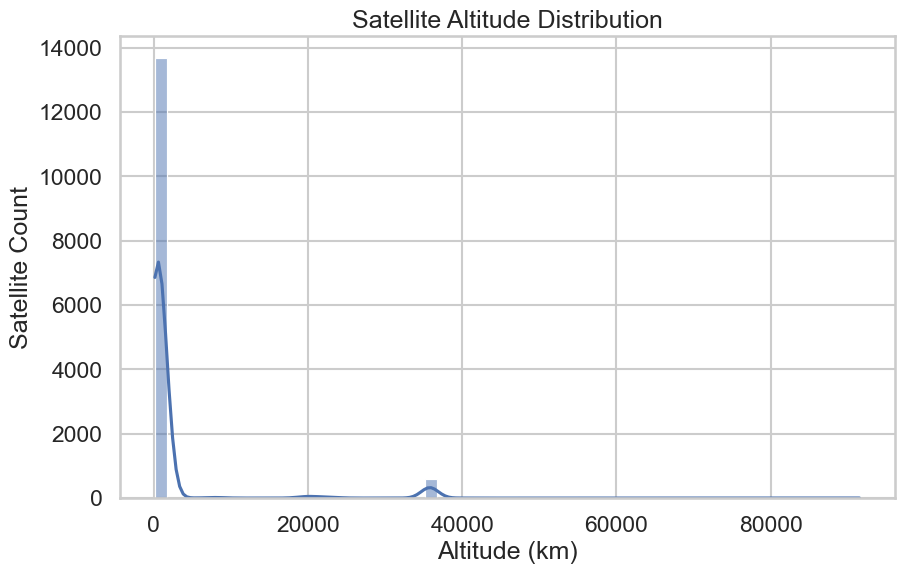

In [10]:
sns.histplot(
    catalog["altitude_km"],
    bins=60,
    kde=True
)

plt.title("Satellite Altitude Distribution")
plt.xlabel("Altitude (km)")
plt.ylabel("Satellite Count")
plt.show()


Orbit Band Distribution (Count + Percentage)

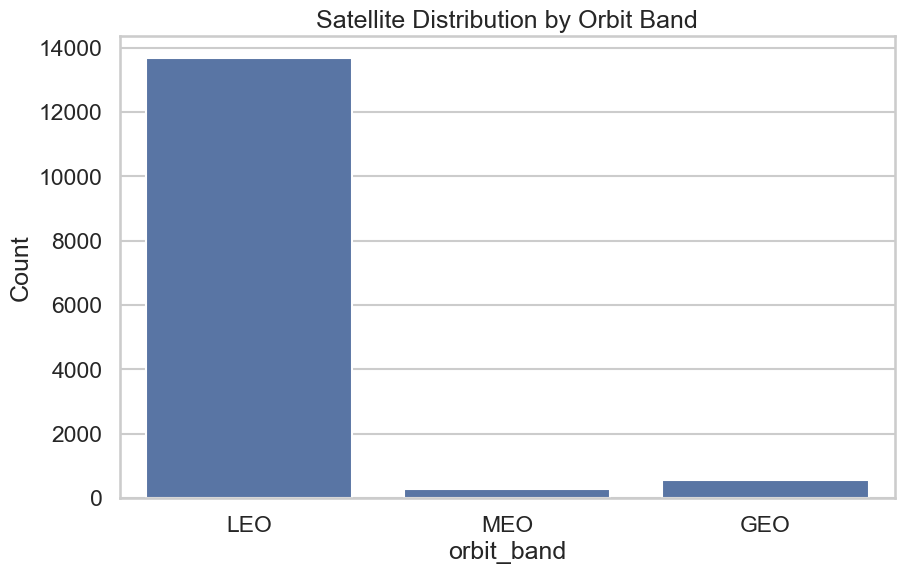

orbit_band
LEO    94.330252
GEO     3.793627
MEO     1.876121
Name: proportion, dtype: float64

In [11]:
orbit_counts = catalog["orbit_band"].value_counts(normalize=True) * 100

sns.countplot(
    x="orbit_band",
    data=catalog,
    order=["LEO", "MEO", "GEO"]
)

plt.title("Satellite Distribution by Orbit Band")
plt.ylabel("Count")
plt.show()

orbit_counts


Inclination vs Altitude (Box + Strip Overlay)

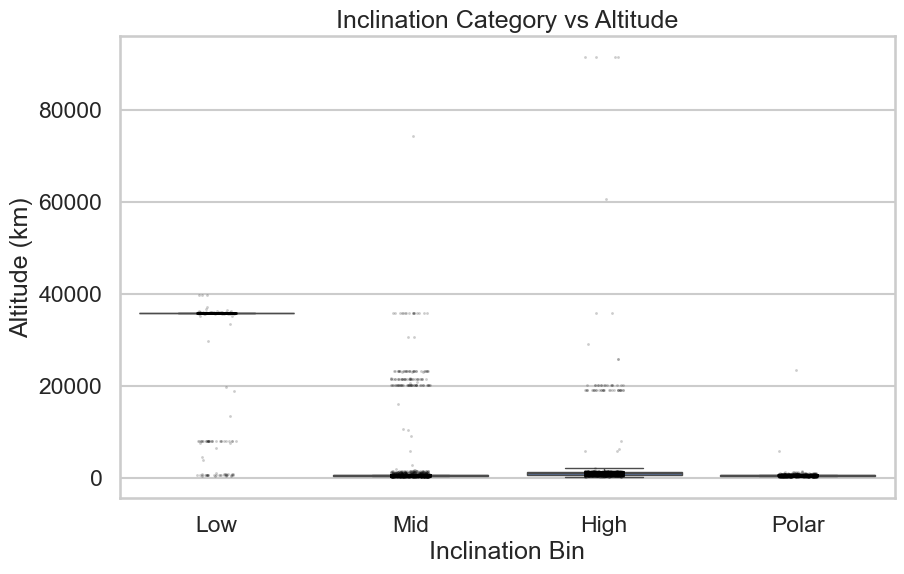

In [12]:
sns.boxplot(
    x="inclination_bin",
    y="altitude_km",
    data=catalog,
    showfliers=False
)

sns.stripplot(
    x="inclination_bin",
    y="altitude_km",
    data=catalog,
    color="black",
    alpha=0.2,
    size=2
)

plt.title("Inclination Category vs Altitude")
plt.xlabel("Inclination Bin")
plt.ylabel("Altitude (km)")
plt.show()


Altitude vs Inclination (Density View)

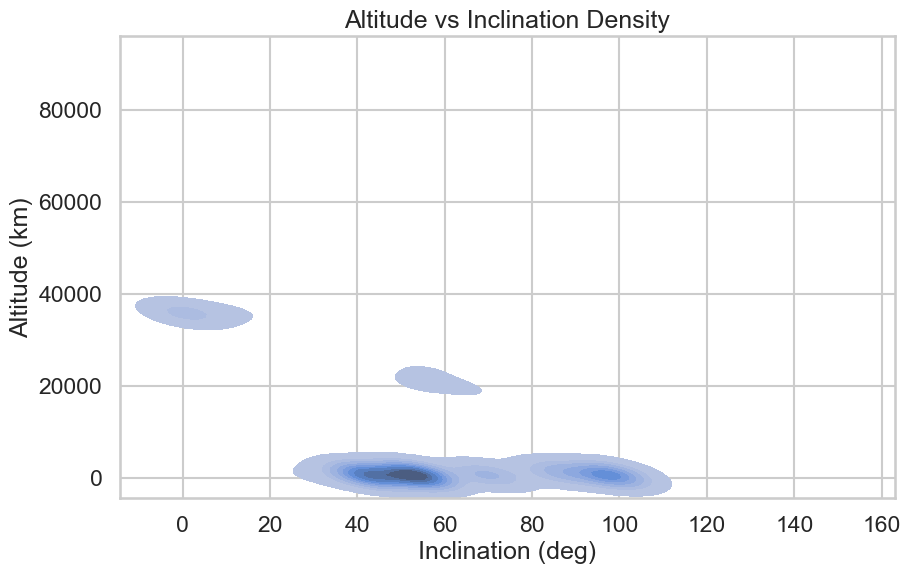

In [13]:
sns.kdeplot(
    x=catalog["inclination"],
    y=catalog["altitude_km"],
    fill=True,
    thresh=0.02
)

plt.title("Altitude vs Inclination Density")
plt.xlabel("Inclination (deg)")
plt.ylabel("Altitude (km)")
plt.show()


Orbital Density Comparison

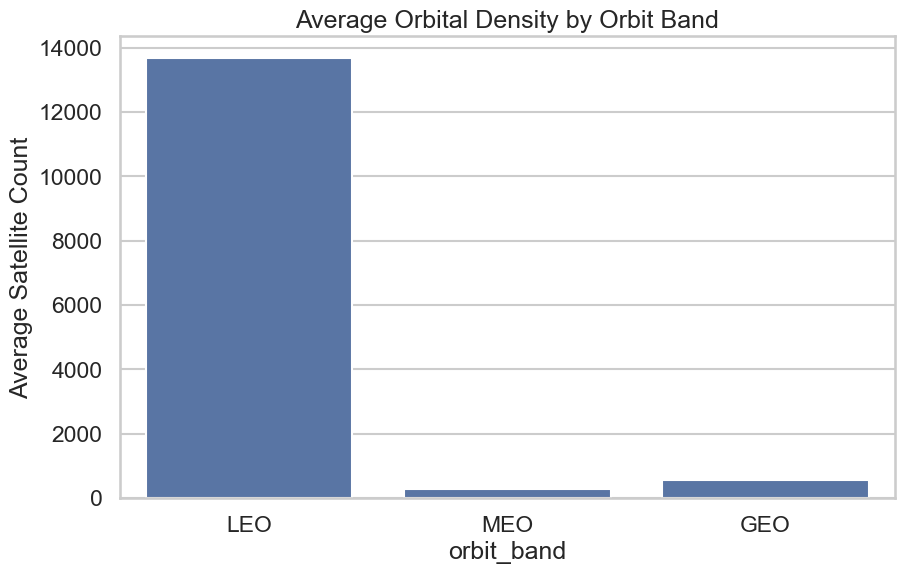

In [14]:
sns.barplot(
    x="orbit_band",
    y="orbital_density",
    data=catalog,
    estimator=np.mean,
    errorbar=None
)

plt.title("Average Orbital Density by Orbit Band")
plt.ylabel("Average Satellite Count")
plt.show()


Correlation Heatmap (Numerical Features)

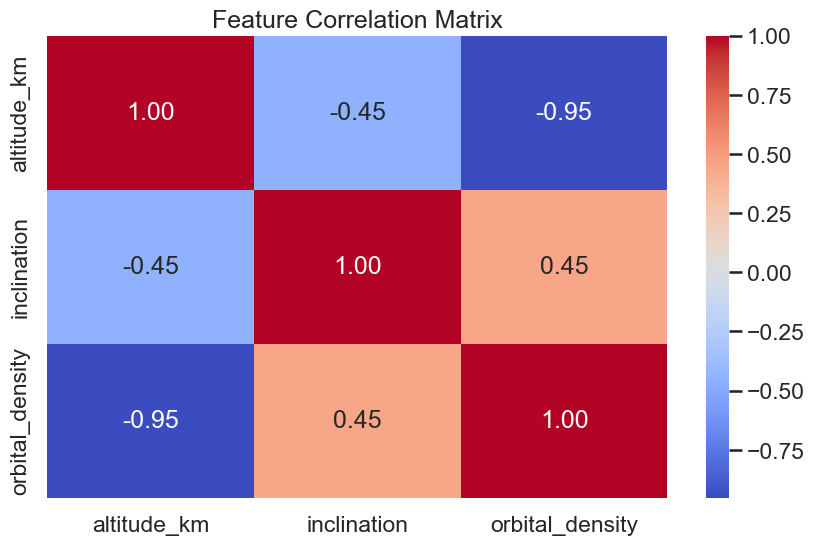

In [15]:
num_cols = [
    "altitude_km",
    "inclination",
    "orbital_density"
]

corr = catalog[num_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Feature Correlation Matrix")
plt.show()


### EDA Summary

- Satellite population is heavily concentrated in LEO
- Orbital density is the dominant congestion driver
- Inclination adds non-linear separation
- Feature interactions justify ML-based congestion modeling
- Data quality is strong after minimal cleaning
